<a href="https://colab.research.google.com/github/CodeHunterOfficial/NLP_Spacy_Python/blob/main/Lecture_3_%D0%90%D1%80%D0%B8%D1%84%D0%BC%D0%B5%D1%82%D0%B8%D0%BA%D0%B0_%D1%81%D0%BB%D0%BE%D0%B2_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D1%8B_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3.  Арифметика слов: векторы TF-IDF 

## План:
*  Подсчет слов и частотностей термов для анализа смысла. 
*  Предсказание вероятностей вхождений слов с помощью закона Ципфа. 
*  Векторные представления слов и способы их использования. 
*  Поиск релевантных документов из корпуса на основе обратных частотностей документов. 
*  Оценка сходства пар документов с помощью коэффициентов Отиаи и метрики Okapi BM25.


В данной лекции мы рассмотрим три набирающих популярность способа представления слов и их значения. 
*  Мультимножества слов — векторы количеств, или частотностей, слов. 
*  Мультимножества n-грамм — векторы количеств пар слов (биграмм), троек слов (триграмм) и т. д. 
* Векторы TF-IDF — показатели слов, наилучшим образом отражающие степень их важности.


## Метод TF-IDF 
TF-­IDF – это частотный метод, учитывающий частоту, с которой слово появляется в корпусе. Он представляет важность конкретного слова в данном документе. Интуитивно понятно, что чем выше частота слова, тем важнее это слово в документе. Например, в документе о кошках слово «кошка» будет встречаться довольно часто. Однако простое вычисление частоты не сработает, потому что такие слова, как «этот», «который», встречаются очень часто, но не содержат столько информации. TF­IDF учитывает это и присваивает нулевой вес подобным распространенным словам. 

TF означает частоту термина (term frequency), а IDF – обратную частоту документа (inverse document frequency):


 

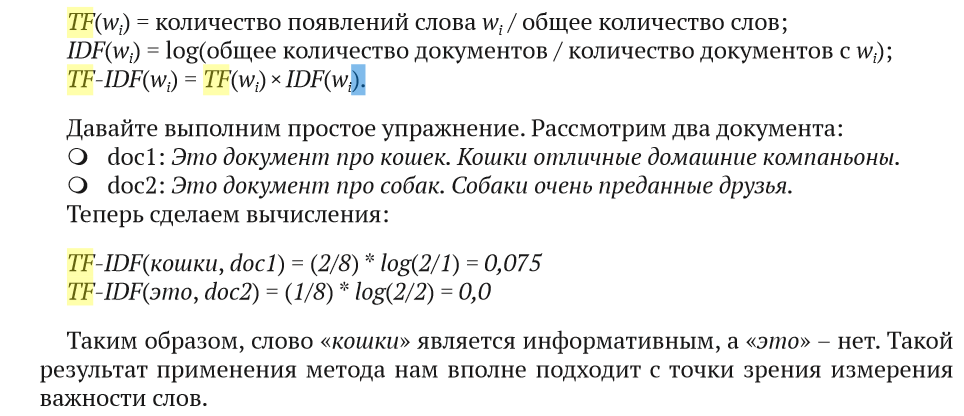

### Мультимножество слов

В предыдущей главе мы создали вашу первую модель векторного пространства текста. Для этого мы создали унитарные представления всех слов, а затем объединили все эти векторы с помощью бинарного OR (или усеченной версии sum) в векторное представление всего текста. Получившийся в результате бинарный вектор мультимножества слов, будучи загруженным в структуру данных вроде DataFrame библиотеки Pandas, оказывается отличным индексом для поиска документов.

Далее мы рассмотрели еще более удобное векторное представление с подсчетом количества вхождений (частотности) слова в тексте. На первый взгляд, чем чаще встречается слово в тексте, тем больший вклад вносит в его смысл. Документ, в котором часто упоминаются «крылья» и «руль», с большей вероятностью связан с самолетами или воздушными путешествиями, чем документ со словами «кошки» и «гравитация». Если некоторые слова были классифицированы как отражающие положительные эмоции — вроде good, best, joy и fantastic, то тональность содержащего их документа, скорее всего, положительная. Впрочем, понятно, что основанный на таких простых правилах алгоритм может легко ошибиться. 

Рассмотрим пример, в котором подсчет частотностей слов оказывается полезным: 

In [ ]:
 from nltk.tokenize import TreebankWordTokenizer 
 sentence = """The faster Harry got to the store, the faster Harry, the faster, would get home.""" 
 tokenizer = TreebankWordTokenizer()
 tokens = tokenizer.tokenize(sentence.lower())
 tokens 

['the',
 'faster',
 'harry',
 'got',
 'to',
 'the',
 'store',
 ',',
 'the',
 'faster',
 'harry',
 ',',
 'the',
 'faster',
 ',',
 'would',
 'get',
 'home',
 '.']

Этот простой список нужен, чтобы выделить из документа уникальные слова и найти их количества. Словарь Python отлично подходит для этой цели. Поскольку необходимо хранить еще и количества вхождений слов, можно воспользоваться типом Counter, как мы делали в предыдущих главах: 

In [ ]:
from collections import Counter
bag_of_words = Counter(tokens)
bag_of_words

Counter({'the': 4,
         'faster': 3,
         'harry': 2,
         'got': 1,
         'to': 1,
         'store': 1,
         ',': 3,
         'would': 1,
         'get': 1,
         'home': 1,
         '.': 1})

Как и в любом хорошем словаре Python, порядок ключей перемешивается. Новый порядок оптимизирован для хранения, обновления и поиска, а не для согласованного отображения. Информация, заключенная в порядке слов исходного высказывания, отбрасывается.


## ПРИМЕЧАНИЕ.

Объект collections.Counter — неупорядоченная коллекция, также называемая мультимножеством. В зависимости от платформы и версии Python счетчик может отображаться в, казалось бы, логичном порядке, например в лексикографическом или в порядке токенов в высказывании. Но рассчитывать на какой-либо определенный порядок токенов (ключей) как в объекте Counter, так и в обычном классе dict языка Python нельзя.


Для коротких документов, как этот, даже в неупорядоченном мультимножестве слов содержится немало информации об исходном подтексте предложения. Причем информации в мультимножестве достаточно для весьма серьезных задач, таких как обнаружение спама, анализ тональности (позитивность, счастье и т. д.), и даже для выявления таких тонких эмоций, как сарказм. Да, это просто набор слов, но наполненный смыслом и информацией. Итак, проранжируем эти слова — отсортируем их в более удобном для понимания порядке. У объекта Counter есть весьма удобный метод most_common, предназначенный именно для этой цели:

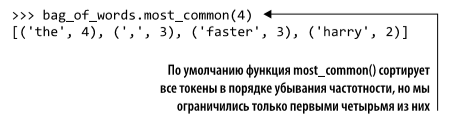

In [ ]:
bag_of_words.most_common(4)

[('the', 4), ('faster', 3), (',', 3), ('harry', 2)]

Количество вхождений слова в заданном документе называется частотностью терма (term frequency, TF). Иногда можно встретить нормализованные путем деления на общее число термов в документе количества слов.

Итак, наши четыре чаще всего встречающихся терма (токена): the, «,», harry и faster. Впрочем, the и запятая не несут много информации об основной мысли этого документа. Скорее всего, эти неинформативные токены будут встречаться вам еще много раз. Поэтому в данном случае их лучше игнорировать, как и целый список стандартных английских стоп-слов и знаков препинания. Конечно, это не всегда имеет смысл делать, но такое решение позволит пока упростить наш пример. Это сокращает список самых употребляемых токенов в векторе TF (мультимножестве слов) до harry и faster.

Подсчитаем частотность терма harry из описанного выше объекта Counter (bag_of_words):


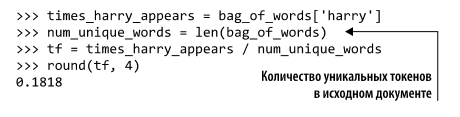

In [ ]:
times_harry_appears=bag_of_words['harry']
num_unique_words=len(bag_of_words)
tf=times_harry_appears/num_unique_words
round(tf, 4)

0.1818

Притормозим и обратим внимание на нормализованную частоту термов — фразу (и сопутствующие ей вычисления), которая встречается на протяжении всего курса. Под этим термином понимается количество слов относительно длины документа. Зачем вообще делить на длину документа? Представим, что dog встречается три раза в документе А и 100 раз в документе B. Это слово явно играет куда более важную роль во втором случае. Но если документ А — письмо ветеринару из 30 слов, а B — «Война и мир» Л. Н. Толстого (приблизительно 580 тыс. слов!)? Тогда наши изначальные выводы меняются на диаметрально противоположные. Следующие уравнения учитывают длину документа: 

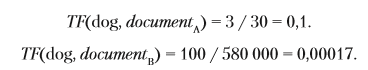

Теперь у вас есть что-то, что позволяет понять разницу между двумя документами, их связь с dog и друг с другом. Таким образом, вместо чистых количеств слов можно использовать для описания документов из корпуса нормализованные частотности термов. Аналогичным образом можно вычислить этот показатель для каждого из слов и узнать относительную важность данного терма для каждого документа. Наш главный герой, Гарри, и его жажда скорости, несомненно, являются центром описанной истории. Мы добились значительных успехов в превращении текста в числа, намного выходящих за пределы фиксации наличия/отсутствия заданного слова в тексте. Очевидно, что это довольно «притянутый за уши» пример, но скоро мы увидим, насколько значимые результаты могут быть получены при таком подходе. Рассмотрим больший фрагмент текста. Возьмем несколько первых абзацев из статьи «Википедии» о воздушных змеях (kites):

A kite is traditionally a tethered heavier-than-air craft with wing surfaces that react against the air to create lift and drag. A kite consists of wings, tethers, and anchors. Kites often have a bridle to guide the face of the kite at the correct angle so the wind can lift it. A kite’s wing also may be so designed so a bridle is not needed; when kiting a sailplane for launch, the tether meets the wing at a single point. A kite may have fixed or moving anchors. Untraditionally in technical kiting, a kite consists of tether-set-coupled wing sets; even in technical kiting, though, a wing in the system is still often called the kite. 

The lift that sustains the kite in flight is generated when air flows around the kite’s surface, producing low pressure above and high pressure below the wings. The interaction with the wind also generates horizontal drag along the direction of the wind. The resultant force vector from the lift and drag force components is opposed by the tension of one or more of the lines or tethers to which the kite is attached. The anchor point of the kite line may be static or moving (such as the towing of a kite by a running person, boat, free-falling anchors as in paragliders and fugitive parakites or vehicle). 

The same principles of fluid flow apply in liquids and kites are also used under water. 

A hybrid tethered craft comprising both a lighter-than-air balloon as well as a kite lifting surface is called a kytoon. 

Kites have a long and varied history and many different types are flown individually and at festivals worldwide. Kites may be flown for recreation, art or other practical uses. Sport kites can be flown in aerial ballet, sometimes as part of a competition. Power kites are multi-line steerable kites designed to generate large forces which can be used to power activities such as kite surfing, kite landboarding, kite fishing, kite buggying and a new trend snow kiting. Even Man-lifting kites have been made.

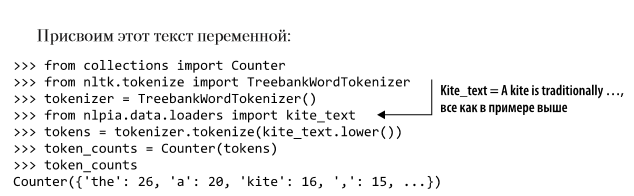

In [2]:
kite_text='A kite is traditionally a tethered heavier-than-air craft with wing surfaces that react\nagainst the air to create lift and drag. A kite consists of wings, tethers, and anchors. Kites\noften have a bridle to guide the face of the kite at the correct angle so the wind can lift it.\nA kite’s wing also may be so designed so a bridle is not needed; when kiting a sailplane\nfor launch, the tether meets the wing at a single point. A kite may have fixed or moving\nanchors. Untraditionally in technical kiting, a kite consists of tether-set-coupled wing\nsets; even in technical kiting, though, a wing in the system is still often called the kite.\nThe lift that sustains the kite in flight is generated when air flows around the kite’s\nsurface, producing low pressure above and high pressure below the wings. The\ninteraction with the wind also generates horizontal drag along the direction of the wind.\nThe resultant force vector from the lift and drag force components is opposed by the\ntension of one or more of the lines or tethers to which the kite is attached. The anchor\npoint of the kite line may be static or moving (such as the towing of a kite by a running\nperson, boat, free-falling anchors as in paragliders and fugitive parakites or vehicle).\nThe same principles of fluid flow apply in liquids and kites are also used under water.\nA hybrid tethered craft comprising both a lighter-than-air balloon as well as a kite lifting\nsurface is called a kytoon.\nKites have a long and varied history and many different types are flown individually and\nat festivals worldwide. Kites may be flown for recreation, art or other practical uses.\nSport kites can be flown in aerial ballet, sometimes as part of a competition. Power kites\nare multi-line steerable kites designed to generate large forces which can be used to\npower activities such as kite surfing, kite landboarding, kite fishing, kite buggying and a\nnew trend snow kiting. Even Man-lifting kites have been made.'

In [3]:
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
#from nlpia.data.loaders import kite_text
tokens = tokenizer.tokenize(kite_text.lower())
token_counts = Counter(tokens)
print(token_counts)

Counter({'the': 26, 'a': 20, 'kite': 14, ',': 14, 'and': 10, 'of': 10, 'kites': 8, 'is': 7, 'in': 7, 'or': 6, 'as': 6, 'wing': 5, 'to': 5, 'be': 5, 'lift': 4, 'have': 4, 'may': 4, 'at': 3, 'so': 3, 'can': 3, 'also': 3, 'kiting': 3, 'are': 3, 'flown': 3, 'tethered': 2, 'craft': 2, 'with': 2, 'that': 2, 'air': 2, 'consists': 2, 'tethers': 2, 'anchors.': 2, 'often': 2, 'bridle': 2, 'wind': 2, 'kite’s': 2, 'designed': 2, ';': 2, 'when': 2, 'for': 2, 'moving': 2, 'technical': 2, 'even': 2, 'called': 2, 'surface': 2, 'pressure': 2, 'drag': 2, 'force': 2, 'by': 2, 'which': 2, 'such': 2, '.': 2, 'used': 2, 'power': 2, 'traditionally': 1, 'heavier-than-air': 1, 'surfaces': 1, 'react': 1, 'against': 1, 'create': 1, 'drag.': 1, 'wings': 1, 'guide': 1, 'face': 1, 'correct': 1, 'angle': 1, 'it.': 1, 'not': 1, 'needed': 1, 'sailplane': 1, 'launch': 1, 'tether': 1, 'meets': 1, 'single': 1, 'point.': 1, 'fixed': 1, 'untraditionally': 1, 'tether-set-coupled': 1, 'sets': 1, 'though': 1, 'system': 1, 'st

### ПРИМЕЧАНИЕ.

TreebankWordTokenizer возвращает kite. (с точкой) в качестве токена. Treebank Tokenizer предполагает, что документ уже был сегментирован на отдельные предложения, поэтому он игнорирует пунктуацию только в конце строки. Сегментация предложений — очень сложный вопрос, и мы будем обсуждать ее только в главе 11. Тем не менее синтаксический анализатор spaCy работает быстрее и точнее, чем Treebank, ввиду того, что он выполняет сегментацию и токенизацию предложений (наряду со многими другими действиями)1 за один проход. Так что лучше применять для реальных приложений spaCy, а не использовавшиеся для простых примеров выше компоненты NLTK.

Ладно, вернемся к примеру. Вы уже заметили огромное количество стоп-слов? Наверняка эта статья из «Википедии» не об артиклях the, a, союзе and и т. д. Их пока отбросим: 

In [4]:
import nltk
nltk.download('stopwords', quiet=True)

True

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
tokens = [x for x in tokens if x not in stopwords]
kite_counts = Counter(tokens)
kite_counts

Counter({'kite': 14,
         'traditionally': 1,
         'tethered': 2,
         'heavier-than-air': 1,
         'craft': 2,
         'wing': 5,
         'surfaces': 1,
         'react': 1,
         'air': 2,
         'create': 1,
         'lift': 4,
         'drag.': 1,
         'consists': 2,
         'wings': 1,
         ',': 14,
         'tethers': 2,
         'anchors.': 2,
         'kites': 8,
         'often': 2,
         'bridle': 2,
         'guide': 1,
         'face': 1,
         'correct': 1,
         'angle': 1,
         'wind': 2,
         'it.': 1,
         'kite’s': 2,
         'also': 3,
         'may': 4,
         'designed': 2,
         'needed': 1,
         ';': 2,
         'kiting': 3,
         'sailplane': 1,
         'launch': 1,
         'tether': 1,
         'meets': 1,
         'single': 1,
         'point.': 1,
         'fixed': 1,
         'moving': 2,
         'untraditionally': 1,
         'technical': 2,
         'tether-set-coupled': 1,
         'sets'

Определенные выводы о содержании документа можно сделать, исходя даже из одной информации о частотностях слов в нем. Слова kite(s), wing и lift обладают большой важностью. Даже если вы не имеете понятия о содержании этого документа и просто наткнулись на него в своей обширной базе данных (масштабов Google), то смогли бы «программным образом» сделать вывод, что он как-то связан с полетами или подъемами в воздух или же с воздушными змеями. 

Если рассматривать несколько документов в корпусе, то все становится немного интереснее. Набор документов может, например, быть целиком посвящен воздушным змеям. Логично предположить, что во всех документах из него упоминается веревка (string) и ветер (wind), а частотность термов TF("string") и TF("wind") будет высокой во всех документах. Теперь рассмотрим способ более изящного представления этих чисел в математических целях. 

# Векторизация 

Мы уже сталкивались с простейшими преобразованиями текста в числа. Но мы просто сохранили числа в словаре, сделав первый шаг из мира текста в мир математики. Теперь мы отправимся дальше по этому пути. Вместо описания документа в терминах частотного словаря мы сформируем из этих количеств слов вектор. В Python он будет представлять собой список, но в общем случае он может быть упорядоченной коллекцией или массивом. Это можно проделать быстро с помощью следующего кода: 

In [6]:
document_vector = []
doc_length = len(tokens)
for key, value in kite_counts.most_common():
  document_vector.append(value / doc_length)
document_vector 

[0.06422018348623854,
 0.06422018348623854,
 0.03669724770642202,
 0.022935779816513763,
 0.01834862385321101,
 0.01834862385321101,
 0.013761467889908258,
 0.013761467889908258,
 0.013761467889908258,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.00

Над этим списком (вектором) можно уже непосредственно производить математические операции.

## ПРИМЕЧАНИЕ.
Существует много способов ускорить обработку подобных структур данных.

Применять математику лишь к одному элементу не очень интересно. Одного вектора для одного документа недостаточно. Лучше взять еще парочку документов и создать для них векторы. Но содержащиеся во всех векторах значения должны относиться к общей точке отсчета. Для проведения с ними вычислений они должны отражать точку в пространстве относительно единого начала координат. Вектору нужны общая точка отсчета и одинаковые масштабы («единицы измерения») в каждом из их измерений. Первый этап данного процесса — нормализация количеств слов путем подсчета нормализованных частотностей термов вместо простых количеств вхождений слов в документе (как мы делали в предыдущем разделе). Второй — приведение всех векторов к единой длине (размеру). 

Кроме того, значение каждого элемента вектора должно отражать одно и то же слово в векторах для всех документов. Но наше письмо ветеринару вряд ли будет включать столько же слов, как «Война и мир» (а может, и будет, кто знает?). Не переживайте, если некоторые из векторов будут содержать нулевые значения на некоторых позициях. Находим все уникальные слова в каждом из наших двух документов, а затем — все уникальные слова в объединении этих двух множеств. Такие наборы слов часто называются лексиконом, что отражает уже встречавшееся нам в предыдущих главах понятие, только в терминах конкретного корпуса. Посмотрим, как это работает с документами немного меньшего размера, нежели «Война и мир». Вернемся к нашему Гарри. У вас уже есть один «документ» о нем, увеличим наш корпус еще на парочку: 

In [8]:
docs = ["The faster Harry got to the store, the faster and faster Harry would get home."]
docs.append("Harry is hairy and faster than Jill.")
docs.append("Jill is not as hairy as Harry.")
docs

['The faster Harry got to the store, the faster and faster Harry would get home.',
 'Harry is hairy and faster than Jill.',
 'Jill is not as hairy as Harry.']

### ПРИМЕЧАНИЕ.
Для удобства, чтобы не набирать эти тексты вручную, вы можете импортировать их из пакета nlpia: from nlpia.data.loaders import harry_docs as docs.

In [10]:
!pip install nlpia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.0 MB 2.4 MB/s 
     |████████████████████████████████| 706 kB 53.5 MB/s 
     |████████████████████████████████| 120 kB 60.6 MB/s 
     |████████████████████████████████| 1.6 MB 50.8 MB/s 
     |████████████████████████████████| 210 kB 61.9 MB/s 
     |████████████████████████████████| 170 kB 61.9 MB/s 
     |████████████████████████████████| 2.2 MB 48.1 MB/s 
     |████████████████████████████████| 82 kB 661 kB/s 


In [11]:
from nlpia.data.loaders import harry_docs as docs
docs

/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/usr/local/lib/python3.7/dist-packages/pugnlp/tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/pugnlp/util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/nlpia

['The faster Harry got to the store, the faster and faster Harry would get home.',
 'Harry is hairy and faster than Jill.',
 'Jill is not as hairy as Harry.']


Взглянем на наш лексикон для корпуса из трех документов: 

In [12]:
doc_tokens = []
for doc in docs:
  doc_tokens += [sorted(tokenizer.tokenize(doc.lower()))]
len(doc_tokens[0]) 

17

In [16]:
doc_tokens

[[',',
  '.',
  'and',
  'faster',
  'faster',
  'faster',
  'get',
  'got',
  'harry',
  'harry',
  'home',
  'store',
  'the',
  'the',
  'the',
  'to',
  'would'],
 ['.', 'and', 'faster', 'hairy', 'harry', 'is', 'jill', 'than'],
 ['.', 'as', 'as', 'hairy', 'harry', 'is', 'jill', 'not']]

In [13]:
all_doc_tokens = sum(doc_tokens, [])
len(all_doc_tokens) 

33

In [15]:
all_doc_tokens

[',',
 '.',
 'and',
 'faster',
 'faster',
 'faster',
 'get',
 'got',
 'harry',
 'harry',
 'home',
 'store',
 'the',
 'the',
 'the',
 'to',
 'would',
 '.',
 'and',
 'faster',
 'hairy',
 'harry',
 'is',
 'jill',
 'than',
 '.',
 'as',
 'as',
 'hairy',
 'harry',
 'is',
 'jill',
 'not']

In [14]:
lexicon = sorted(set(all_doc_tokens))
len(lexicon)

18

In [18]:
lexicon

[',',
 '.',
 'and',
 'as',
 'faster',
 'get',
 'got',
 'hairy',
 'harry',
 'home',
 'is',
 'jill',
 'not',
 'store',
 'than',
 'the',
 'to',
 'would']

Каждый из трех векторов документов должен содержать 18 значений, даже если в соответствующем документе содержатся не все 18 слов из лексикона. Каждому токену выделяется место в векторах в соответствии с его позицией в лексиконе. Некоторые из этих количеств токенов будут равны нулю, что нам, собственно, и нужно: 

In [19]:
from collections import OrderedDict
zero_vector = OrderedDict((token, 0) for token in lexicon)
zero_vector

OrderedDict([(',', 0),
             ('.', 0),
             ('and', 0),
             ('as', 0),
             ('faster', 0),
             ('get', 0),
             ('got', 0),
             ('hairy', 0),
             ('harry', 0),
             ('home', 0),
             ('is', 0),
             ('jill', 0),
             ('not', 0),
             ('store', 0),
             ('than', 0),
             ('the', 0),
             ('to', 0),
             ('would', 0)])

Далее мы копируем базовый вектор, обновляем его значения для каждого документа и сохраняем в массиве:

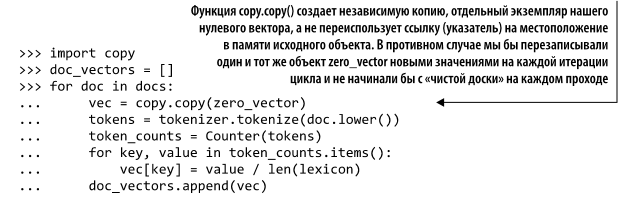

In [20]:
import copy
doc_vectors = []
for doc in docs:
    vec = copy.copy(zero_vector)
    tokens = tokenizer.tokenize(doc.lower())
    token_counts = Counter(tokens)
    for key, value in token_counts.items():
        vec[key] = round(value / len(lexicon), 4)
    doc_vectors.append(vec)

for i, doc_vec in enumerate(doc_vectors):
    print("{} : {}".format(i + 1, doc_vec), '\n')

1 : OrderedDict([(',', 0.0556), ('.', 0.0556), ('and', 0.0556), ('as', 0), ('faster', 0.1667), ('get', 0.0556), ('got', 0.0556), ('hairy', 0), ('harry', 0.1111), ('home', 0.0556), ('is', 0), ('jill', 0), ('not', 0), ('store', 0.0556), ('than', 0), ('the', 0.1667), ('to', 0.0556), ('would', 0.0556)]) 

2 : OrderedDict([(',', 0), ('.', 0.0556), ('and', 0.0556), ('as', 0), ('faster', 0.0556), ('get', 0), ('got', 0), ('hairy', 0.0556), ('harry', 0.0556), ('home', 0), ('is', 0.0556), ('jill', 0.0556), ('not', 0), ('store', 0), ('than', 0.0556), ('the', 0), ('to', 0), ('would', 0)]) 

3 : OrderedDict([(',', 0), ('.', 0.0556), ('and', 0), ('as', 0.1111), ('faster', 0), ('get', 0), ('got', 0), ('hairy', 0.0556), ('harry', 0.0556), ('home', 0), ('is', 0.0556), ('jill', 0.0556), ('not', 0.0556), ('store', 0), ('than', 0), ('the', 0), ('to', 0), ('would', 0)]) 



Итак, у нас есть три вектора. По одному на каждый документ. «И что дальше? Что мы можем с ними сделать?» — спросите вы. С векторами, содержащими количества слов, можно делать множество интересных вещей, как и с любыми другими, так что сначала узнаем больше о векторах и векторных пространствах1